In [1]:
#main libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#vectorizors
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [3]:
#performence metrics
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [4]:
#modules for building ML model
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

## Objective

1. use BernoulliNB(), MultinomialNB().

2. find right 'alpha' using 10fold cv.

3. Build Naive bayes with featurisation techniques like BOW, TFIDF AVGW2V2 TFIDFW2V.

4. get accuracy, precision scores, confusion matrrix, recall score, f1 score.

5. get important features for +ve and -ve class.

In [5]:
#connect sql database
con = sqlite3.connect('final.sqlite')

In [6]:
#read sql data using pandas
data = pd.read_sql("SELECT * FROM REVIEWS", con)

In [7]:
def partition(x) :
    if x == 'positive' :
        return 1
    return 0

actualscore = data['Score']
positivenegative = actualscore.map(partition)
data['Score'] = positivenegative

In [8]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


Number of positive & negative data points are 
 1    307061
0     57110
Name: Score, dtype: int64


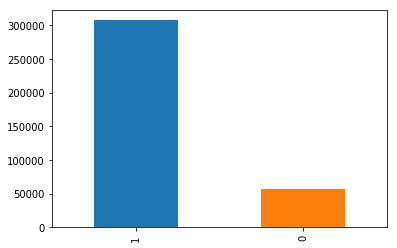

In [9]:
print ('Number of positive & negative data points are \n',data['Score'].value_counts())
data['Score'].value_counts().plot(kind='bar')

In [10]:
#sort data based on time
df_time_sorted = data.sort_values('Time', kind ='quicksort')

In [11]:
df_time_sorted.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


The important piece of information from dataset for building ML models are text reviews and their Scores if they are positive or negative so lets seperate only those two columns into a seperate dataframe using pandas

In [12]:
df = pd.DataFrame(data, columns=['CleanedText', 'Score'])
df.head()

,CleanedText,Score
0,witti littl book make son laugh loud recit car...,1
1,grew read sendak book watch realli rosi movi i...,1
2,fun way children learn month year learn poem t...,1
3,great littl book read nice rhythm well good re...,1
4,book poetri month year goe month cute littl po...,1


In [13]:
#lets check the total dataset values
df.shape

(364171, 2)

Number of +ve & -ve datapoints 
 1    307061
0     57110
Name: Score, dtype: int64


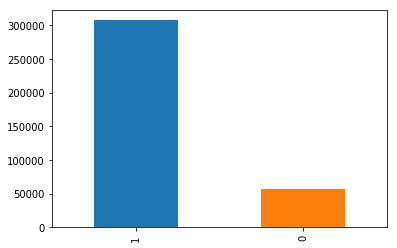

In [14]:
df_sample = df
print ('Number of +ve & -ve datapoints \n' ,df_sample['Score'].value_counts())
df_sample['Score'].value_counts().plot(kind='bar')

In [15]:
X = df_sample['CleanedText']
y = df_sample['Score']
print (X.shape)
print (y.shape)

(364171,)
(364171,)


###### Since the data is time based. we split the data into test-train in temporal manner and not random. where first 80% of data is taken into train and rest 20% into test.

###### To achieve this in test_train_split we use shuffle=False. so the data doesnt split in random manner.

In [16]:
#test-train-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=False)
print('X_train shape :' ,X_train.shape)
print('y_train shape :' ,y_train.shape)
print('X_test shape :' ,X_test.shape)
print('y_test shape :' ,y_test.shape)

X_train shape : (254919,)
y_train shape : (254919,)
X_test shape : (109252,)
y_test shape : (109252,)


In [17]:
X_train.head()

0    witti littl book make son laugh loud recit car...
1    grew read sendak book watch realli rosi movi i...
2    fun way children learn month year learn poem t...
3    great littl book read nice rhythm well good re...
4    book poetri month year goe month cute littl po...
Name: CleanedText, dtype: object

In [18]:
X_train.tail()

254914       havent found decaff serv challah one give rebb
254915    purchas coffe base posit feedback either got b...
254916    drank communiti coffe mani year recent becam c...
254917    bought pack give other kept one tri glad great...
254918    love communiti coffe yummi strong without grea...
Name: CleanedText, dtype: object

In [19]:
X_test.head()

254919    word want reduc caffienn brand best choic use ...
254920    louisiana nativ like peopl louisiana drink com...
254921    drink number brand coffe definit dont enjoy fi...
254922    purchas great price amazon pleas flavor buddi ...
254923    love coffe still block form fresh communiti co...
Name: CleanedText, dtype: object

In [20]:
X_test.head()

254919    word want reduc caffienn brand best choic use ...
254920    louisiana nativ like peopl louisiana drink com...
254921    drink number brand coffe definit dont enjoy fi...
254922    purchas great price amazon pleas flavor buddi ...
254923    love coffe still block form fresh communiti co...
Name: CleanedText, dtype: object

In [21]:
#get train and cv 10fold shapes
cv= TimeSeriesSplit(n_splits=10)
for train, cv in cv.split(X_train):
    print(X_train[train].shape, X_train[cv].shape)

(23179,) (23174,)
(46353,) (23174,)
(69527,) (23174,)
(92701,) (23174,)
(115875,) (23174,)
(139049,) (23174,)
(162223,) (23174,)
(185397,) (23174,)
(208571,) (23174,)
(231745,) (23174,)


# NAIVE-BAYES

1. Naive bayes are based on principle of Conditional independence i.e each features(words) are completly independent to each other.

2. Naive bayes classifier in SKlearn has two functions BernoulliNB() & MultinomialNB.

3. BernoulliNB is used when word occurences are counted as binary (i.e if a word is present it gives value 1, if not present then 0). if CountVectorizer(binary=True), TfidfVectorizer(binary=True).

4. MultinomialNB takes the number of occurences of words in documents. most generally MultinomialNB() is used in Naive-Bayes.

5. word2vec fails drastically fails on Naive-Bayes since the words are sematically co-realted vectors.

# Functions to find Hyperparameter & Use Naive-Bayes

In [22]:
#c=1/lambda, lambda = 0.001,0.002,0.01,0.02,0.1,0.2,1,2,10,20,100,200,1000,2000,10000. 
def MNB_best_params (X_train, y_train) :
    clf = MultinomialNB()
    cv= TimeSeriesSplit(n_splits=10)
    param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
    grid_cv = GridSearchCV(clf, param_grid, cv=cv, verbose=1, n_jobs=-1)
    grid_cv.fit(X_train,y_train)
    print("Best HyperParameter: ",grid_cv.best_params_)
    print("Best Accuracy: ", (grid_cv.best_score_*100))
    #Function for cv_error vs alpha plot
    plt.figure(figsize=(10,6))
    plt.xlabel('Alpha in NB')
    plt.ylabel('Best Score')
    plt.plot(param_grid['alpha'], grid_cv.cv_results_['mean_test_score'], marker='o',markerfacecolor='green', markersize=10)

In [23]:
def MNB(alpha, X_train, y_train, X_test, Y_test) :
    clf = BernoulliNB(alpha=alpha)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy: ", (metrics.accuracy_score(y_test, y_pred)*100))
    print("F1-Score: ",round(f1_score(y_test, y_pred) * float(100)))
    print("Precision-Score: ",round(precision_score(y_test, y_pred) * float(100)))
    print("Recall-Score : ",round(recall_score(y_test, y_pred) * float(100)))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')

# BAG of WORDS

In [24]:
vect = CountVectorizer()

In [25]:
from sklearn import preprocessing
bow_X_train = vect.fit_transform(X_train)
bow_X_train = preprocessing.normalize(bow_X_train)
bow_X_train

<254919x59601 sparse matrix of type '<class 'numpy.float64'>'
	with 7863068 stored elements in Compressed Sparse Row format>

In [26]:
bow_X_test = vect.transform(X_test)
bow_X_test = preprocessing.normalize(bow_X_test)
bow_X_test

<109252x59601 sparse matrix of type '<class 'numpy.float64'>'
	with 3581565 stored elements in Compressed Sparse Row format>

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   43.4s finished


Best HyperParameter:  {'alpha': 0.005}
Best Accuracy:  87.46051609562441


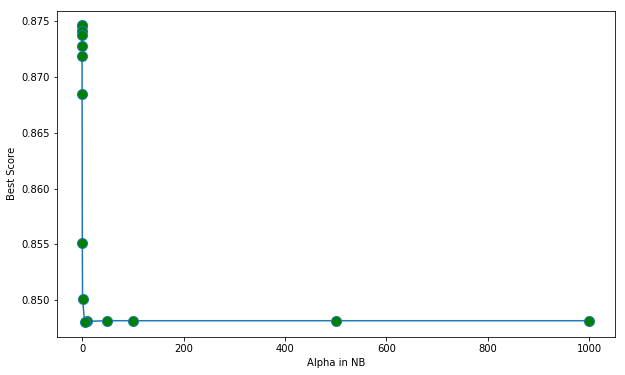

In [27]:
MNB_best_params(bow_X_train, y_train)

Accuracy:  88.08717460549921
F1-Score:  93.0
Precision-Score:  92.0
Recall-Score :  93.0


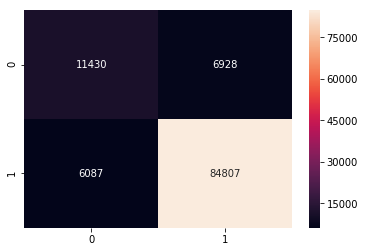

In [28]:
MNB(0.005, bow_X_train, y_train, bow_X_test, y_test)

In [33]:
### Most Important Features

In [35]:
bow_1 = CountVectorizer()
bow_2 = bow_1.fit_transform(X_train.values)
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(bow_1,NB)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative						Positive
________________________________________________________________________________________________
	-10.4069	aachen         				-1.2896	love           
	-10.4069	abbrevi        				-1.2964	like           
	-10.4069	aberr          				-1.3265	great          
	-10.4069	abouit         				-1.3415	tast           
	-10.4069	acc            				-1.3606	good           
	-10.4069	accusatori     				-1.3710	use            
	-10.4069	acknowleg      				-1.5057	one            
	-10.4069	actal          				-1.5501	product        
	-10.4069	addag          				-1.5862	tri            
	-10.4069	addicitv       				-1.6016	flavor         
	-10.4069	adio           				-1.6240	make           
	-10.4069	adovada        				-1.6878	get            
	-10.4069	adress         				-1.8521	time           
	-10.4069	adver          				-1.9693	best           
	-10.4069	adverag        				-1.9821	buy            
	-10.4069	adversis       				-1.9868	find           
	-10.4069	advertiz       				

# TFIDF

In [29]:
vect = TfidfVectorizer()

In [30]:
from sklearn import preprocessing
tfidf_X_train = vect.fit_transform(X_train)
tfidf_X_train = preprocessing.normalize(tfidf_X_train)
tfidf_X_train

<254919x59601 sparse matrix of type '<class 'numpy.float64'>'
	with 7863068 stored elements in Compressed Sparse Row format>

In [31]:
tfidf_X_test = vect.transform(X_test)
tfidf_X_test = preprocessing.normalize(tfidf_X_test)
tfidf_X_test

<109252x59601 sparse matrix of type '<class 'numpy.float64'>'
	with 3581565 stored elements in Compressed Sparse Row format>

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   43.9s finished


Best HyperParameter:  {'alpha': 0.01}
Best Accuracy:  87.77164063174247


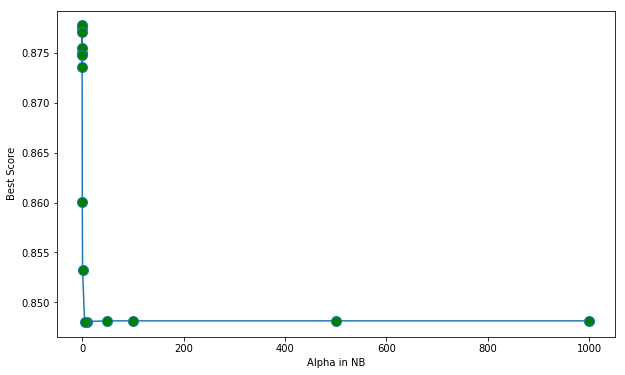

In [32]:
MNB_best_params(tfidf_X_train, y_train)

Accuracy:  88.12653315271116
F1-Score:  93.0
Precision-Score:  93.0
Recall-Score :  93.0


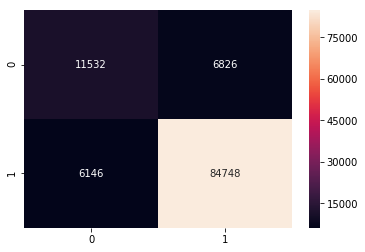

In [33]:
MNB(0.01, tfidf_X_train, y_train, tfidf_X_test, y_test)

### TFIDF most important features

In [34]:
tfidf_1 = TfidfVectorizer()
tfidf_2 = tfidf_1.fit_transform(X_train.values)
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf_1,NB)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative						Positive
________________________________________________________________________________________________
	-10.4069	aachen         				-1.2896	love           
	-10.4069	abbrevi        				-1.2964	like           
	-10.4069	aberr          				-1.3265	great          
	-10.4069	abouit         				-1.3415	tast           
	-10.4069	acc            				-1.3606	good           
	-10.4069	accusatori     				-1.3710	use            
	-10.4069	acknowleg      				-1.5057	one            
	-10.4069	actal          				-1.5501	product        
	-10.4069	addag          				-1.5862	tri            
	-10.4069	addicitv       				-1.6016	flavor         
	-10.4069	adio           				-1.6240	make           
	-10.4069	adovada        				-1.6878	get            
	-10.4069	adress         				-1.8521	time           
	-10.4069	adver          				-1.9693	best           
	-10.4069	adverag        				-1.9821	buy            
	-10.4069	adversis       				-1.9868	find           
	-10.4069	advertiz       				

# NAIVE-BAYES WITH BERNOULLINB()

In [34]:
#c=1/lambda, lambda = 0.001,0.002,0.01,0.02,0.1,0.2,1,2,10,20,100,200,1000,2000,10000. 
def NB_best_params (X_train, y_train) :
    clf = BernoulliNB()
    cv= TimeSeriesSplit(n_splits=10)
    param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
    grid_cv = GridSearchCV(clf, param_grid, cv=cv, verbose=1, n_jobs=-1)
    grid_cv.fit(X_train,y_train)
    print("Best HyperParameter: ",grid_cv.best_params_)
    print("Best Accuracy: ", (grid_cv.best_score_*100))
    #Function for cv_error vs alpha plot
    plt.figure(figsize=(10,6))
    plt.xlabel('Alpha in NB')
    plt.ylabel('Best Score')
    plt.plot(param_grid['alpha'], grid_cv.cv_results_['mean_test_score'], marker='o',markerfacecolor='green', markersize=10)

In [35]:
def NB(alpha, X_train, y_train, X_test, Y_test) :
    clf = BernoulliNB(alpha=alpha)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy: ", (metrics.accuracy_score(y_test, y_pred)*100))
    print("F1-Score: ",round(f1_score(y_test, y_pred) * float(100)))
    print("Precision-Score: ",round(precision_score(y_test, y_pred) * float(100)))
    print("Recall-Score : ",round(recall_score(y_test, y_pred) * float(100)))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')

# BAG of WORDS

In [36]:
vect = CountVectorizer(binary=True)

In [37]:
from sklearn import preprocessing
bow_X_train = vect.fit_transform(X_train)
bow_X_train = preprocessing.normalize(bow_X_train)
bow_X_train

<254919x59601 sparse matrix of type '<class 'numpy.float64'>'
	with 7863068 stored elements in Compressed Sparse Row format>

In [38]:
bow_X_test = vect.transform(X_test)
bow_X_test = preprocessing.normalize(bow_X_test)
bow_X_test

<109252x59601 sparse matrix of type '<class 'numpy.float64'>'
	with 3581565 stored elements in Compressed Sparse Row format>

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   48.3s finished


Best HyperParameter:  {'alpha': 0.05}
Best Accuracy:  88.44869250021577


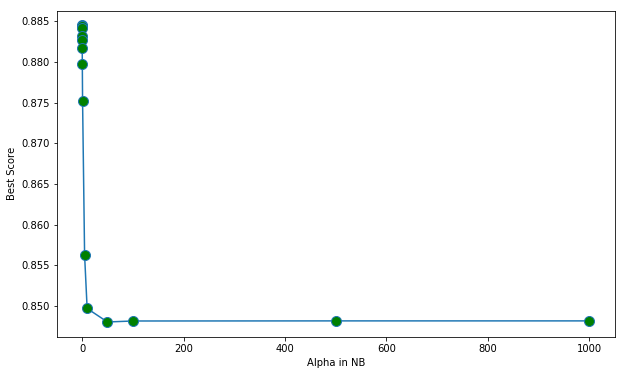

In [39]:
NB_best_params(bow_X_train, y_train)

Accuracy:  88.10914216673379
F1-Score:  93.0
Precision-Score:  93.0
Recall-Score :  93.0


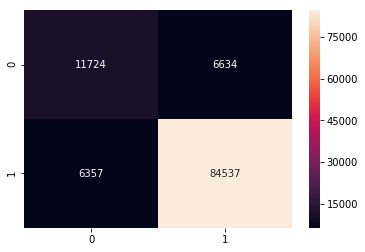

In [40]:
NB(0.05, bow_X_train, y_train, bow_X_test, y_test)

# TFIDF

In [41]:
vect = TfidfVectorizer(binary=True)

In [42]:
from sklearn import preprocessing
tfidf_X_train = vect.fit_transform(X_train)
tfidf_X_train = preprocessing.normalize(tfidf_X_train)
tfidf_X_train

<254919x59601 sparse matrix of type '<class 'numpy.float64'>'
	with 7863068 stored elements in Compressed Sparse Row format>

In [43]:
tfidf_X_test = vect.transform(X_test)
tfidf_X_test = preprocessing.normalize(tfidf_X_test)
tfidf_X_test

<109252x59601 sparse matrix of type '<class 'numpy.float64'>'
	with 3581565 stored elements in Compressed Sparse Row format>

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   45.4s finished


Best HyperParameter:  {'alpha': 0.05}
Best Accuracy:  88.44869250021577


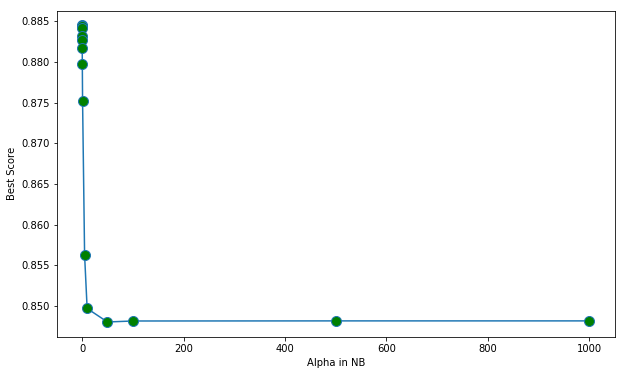

In [44]:
NB_best_params(tfidf_X_train, y_train)

Accuracy:  88.10914216673379
F1-Score:  93.0
Precision-Score:  93.0
Recall-Score :  93.0


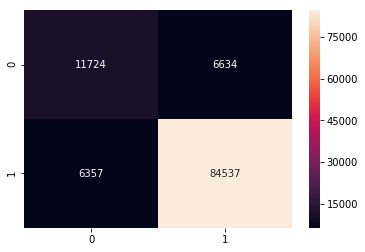

In [45]:
NB(0.05, tfidf_X_train, y_train, tfidf_X_test, y_test)

# Feature Imporatnce

In [164]:
nb = MultinomialNB(alpha=0.005)
nb.fit(bow_X_train, y_train)

MultinomialNB(alpha=0.005, class_prior=None, fit_prior=True)

In [165]:
#get first 10 features
vect.get_feature_names()[:10]

['aa',
 'aaa',
 'aaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaargh',
 'aaaaaaaaagghh',
 'aaaaaaarrrrrggghhh',
 'aaaaaah',
 'aaaaaahhhhhyaaaaaa',
 'aaaaaand']

In [166]:
#get all features
vect.get_feature_names()[4990:5000]

['bewteen',
 'bewtter',
 'beyon',
 'beyond',
 'beyondhealth',
 'beyound',
 'bezo',
 'bezzera',
 'bfast',
 'bff']

In [167]:
# number of times a word occur in each class
nb.feature_count_

array([[0.        , 0.10846523, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.18390036, 1.85169547, 0.17149859, ..., 0.21821789, 0.21821789,
        0.18569534]])

In [168]:
# number of times a word occur in negative class
negative = nb.feature_count_[0]
negative


array([0.        , 0.10846523, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [169]:
# number of times a word occur in positive class
positive = nb.feature_count_[1]
positive

array([0.18390036, 1.85169547, 0.17149859, ..., 0.21821789, 0.21821789,
       0.18569534])

In [170]:
words = pd.DataFrame({'words': vect.get_feature_names(), 'negative': negative, 'positive': positive})
words.head()

,words,negative,positive
0,aa,0.000000,0.183900
1,aaa,0.108465,1.851695
2,aaaa,0.000000,0.171499
3,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,0.000000,0.250000
4,aaaaaaaaaaaaaaaaaaaargh,0.000000,0.149071


In [171]:
# lets find #1 important word found in most of documents
imp_positive_word = words.iloc[words['positive'].argmax()]
imp_negative_word = words.iloc[words['negative'].argmax()]
print('Positive: \n' ,imp_positive_word)
print('--'*10)
print('Negative: \n' ,imp_negative_word)

Positive: 
 words         love
negative    768.44
positive     12488
Name: 30590, dtype: object
--------------------
Negative: 
 words          tast
negative    3057.34
positive    12155.8
Name: 51562, dtype: object


In [172]:
# lets add weights of each feature to dataframe
w = nb.coef_
print((w).T.shape)
print(words.shape)
words['weights'] = (w).T 
words.head()

(59601, 1)
(59601, 3)


,words,negative,positive,weights
0,aa,0.000000,0.183900,-15.522352
1,aaa,0.108465,1.851695,-13.237018
2,aaaa,0.000000,0.171499,-15.590259
3,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,0.000000,0.250000,-15.222308
4,aaaaaaaaaaaaaaaaaaaargh,0.000000,0.149071,-15.726157


In [173]:
words.loc[words['weights'].argmax()]

words          love
negative     768.44
positive      12488
weights    -4.42329
Name: 30590, dtype: object

### Most Important Words of Positive Class

In [178]:
# important words of positive class
sorted_words_positive = words.sort_values('positive', ascending=False)
sorted_words_positive.drop('negative', axis=1).head(25)

,words,positive,weights
30590,love,12488.037027,-4.423290
22487,great,12278.876101,-4.440180
51562,tast,12155.794395,-4.450255
29913,like,12129.118940,-4.452452
22002,good,11811.024980,-4.479027
19348,flavor,9803.080638,-4.665364
55665,use,9712.166215,-4.674681
41146,product,9601.030360,-4.686190
36723,one,8510.302003,-4.806783
51711,tea,8128.262396,-4.852713


In [177]:
# important words of negative class
sorted_words_negative = words.sort_values('negative', ascending=False)
sorted_words_negative.drop('positive', axis=1).head(25)

,words,negative,weights
51562,tast,3057.336209,-4.450255
29913,like,2694.375407,-4.452452
41146,product,2522.880493,-4.686190
36723,one,1718.840329,-4.806783
19348,flavor,1567.082971,-4.665364
58458,would,1505.043411,-5.393931
53747,tri,1436.285639,-4.911457
22002,good,1354.542007,-4.479027
7258,buy,1342.526150,-5.185556
37015,order,1257.054977,-5.309158


# Lets compare the reviews with their probability to which class it belongs

In [139]:
nb.predict_proba(bow_X_test).shape

(109252, 2)

In [156]:
words_with_probailitites = pd.DataFrame({'words': X_test, 'negative probability':nb.predict_proba(bow_X_test)[:,0], 'positive probability':nb.predict_proba(bow_X_test)[:,1], 'true_class': y_test})
words_with_probailitites.head()

,words,negative probability,positive probability,true_class
254919,word want reduc caffienn brand best choic use ...,0.080737,0.919263,1
254920,louisiana nativ like peopl louisiana drink com...,0.052268,0.947732,1
254921,drink number brand coffe definit dont enjoy fi...,0.064091,0.935909,1
254922,purchas great price amazon pleas flavor buddi ...,0.041237,0.958763,0
254923,love coffe still block form fresh communiti co...,0.078502,0.921498,1


In [157]:
#reviews that are actually negative
words_with_probailitites[words_with_probailitites['true_class'] == 0].head()

,words,negative probability,positive probability,true_class
364097,unimpress almond clovey musti tast expect swee...,0.396581,0.603419,0
364114,spice tast harsh raw weird tast mayb much asaf...,0.187941,0.812059,0
364125,realli gross tast like calori worth chocol pea...,0.328486,0.671514,0
364141,trader joe product good qualiti buy straight t...,0.387797,0.612203,0
364144,wateri tasteless pinot noir planet cali tool m...,0.464924,0.535076,0


In [144]:
#reviews that are actually positive
words_with_probailitites[words_with_probailitites['true_class'] == 1].head()

,words,negative probability,positive probability,true_class
254919,word want reduc caffienn brand best choic use ...,0.080737,0.919263,1
254920,louisiana nativ like peopl louisiana drink com...,0.052268,0.947732,1
254921,drink number brand coffe definit dont enjoy fi...,0.064091,0.935909,1
254923,love coffe still block form fresh communiti co...,0.078502,0.921498,1
254924,truli wonder high suggest flavor mild alway fe...,0.040961,0.959039,1


# RESULTS

In [49]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["MODEL", "BEST alpha", "ACCURACY", "F1-SCORE", "PRECISION", "RECALL" ]
#BOW
x.add_row(['BOW with BERNOULLINB', 0.05, 88.1, 93, 93, 93 ])
x.add_row(["BOW with MULTINOMIALNB", 0.005, 88.12, 93, 92, 93 ])
x.add_row(['--'*5,'-'*5,'-'*8,'-'*5, '--'*5, '--'*5])
#TFIDF
x.add_row(['TFIDF with BERNOULLINB', 0.05, 88.08, 93, 93, 93 ])
x.add_row(["TFIDF with MULTINOMIALNB", 0.01, 88.10, 93, 93, 93 ])
x.add_row(['--'*5,'-'*8,'-'*8,'-'*5, '--'*5, '--'*5])
#AVGW2V
x.add_row(['AVGW2V with BERNOULLINB', '---' , '---', '---', '---', '---'])
x.add_row(["AVGW2V with MULTINOMIALNB", '---' ,'---' ,'---' ,'---', '---'])
x.add_row(['--'*5,'-'*8,'-'*8,'-'*5, '--'*5, '--'*5])
#TFIDFW2V
x.add_row(['TFIDFW2V with BERNOULLINB', '---' , '---', '---', '---', '---' ])
x.add_row(["TFIDFW2V with MULTINOMIALNB", '---' , '---', '---', '---', '---'])
print(x)

+-----------------------------+------------+----------+----------+------------+------------+
|            MODEL            | BEST alpha | ACCURACY | F1-SCORE | PRECISION  |   RECALL   |
+-----------------------------+------------+----------+----------+------------+------------+
|     BOW with BERNOULLINB    |    0.05    |   88.1   |    93    |     93     |     93     |
|    BOW with MULTINOMIALNB   |   0.005    |  88.12   |    93    |     92     |     93     |
|          ----------         |   -----    | -------- |  -----   | ---------- | ---------- |
|    TFIDF with BERNOULLINB   |    0.05    |  88.08   |    93    |     93     |     93     |
|   TFIDF with MULTINOMIALNB  |    0.01    |   88.1   |    93    |     93     |     93     |
|          ----------         |  --------  | -------- |  -----   | ---------- | ---------- |
|   AVGW2V with BERNOULLINB   |    ---     |   ---    |   ---    |    ---     |    ---     |
|  AVGW2V with MULTINOMIALNB  |    ---     |   ---    |   ---    |    

In [50]:
#number of positive and negative values in test data
y_test.value_counts()

1    90894
0    18358
Name: Score, dtype: int64

**OBSERVATIONS**


1. the test error is showing same over all the vectorisations but actual results are known by seeing confusion matrix.


2. confusion matrix = [tn fp] [fn tp]

        tn - actual class and predicted class are both negative

        tp - actual class and predicted class are both positive

        fn - actual class is positive but model wrongly classified as negative[Falsdely classified negative data points]

        fp - actual class is negative model,wrongly classified as positive. [falsely classified


3. The Accuracy is same for all vectorizers, But the Precision is high with MultinomialNB() on TFIDF.

4. tried with Word2Vec too, But it failed with MultinomialNB() it pointed out errors as negative value. it may be because words are corellated and conditional independence principle not satisfied.


**4. this current model is so much biased towards positive data since large amount of points belongs to positive class. this can be little bit solved using upsampling.**